# QAOA Travelling Salesman Problem

In [1]:
import numpy as np
%matplotlib inline


def points_to_binary_state(points_order):
    number_of_points = len(points_order)
    binary_state = np.zeros((len(points_order))**2)
    for j in range(len(points_order)):
        p = points_order[j]
        binary_state[(number_of_points) * (j) + (p)] = 1
    return binary_state

def binary_to_points_order(binary_state):
    points_order = []
    number_of_points = int(np.sqrt(len(binary_state)))
    for p in range(number_of_points):
        for j in range(number_of_points):
            if binary_state[(number_of_points) * p + j] == 1:
                points_order.append(j)
    return points_order

In [2]:
Points_order = [0, 1, 2]
Binary_state = points_to_binary_state(Points_order)
Points_order_again = binary_to_points_order(Binary_state)

print("Binary Representation :->", Points_order, "is", Binary_state)
print(Points_order_again, "must be equal to", Points_order)

Binary representation of  [0, 1, 2] is [1. 0. 0. 0. 1. 0. 0. 0. 1.]
[0, 1, 2] should be equal to [0, 1, 2]


Now that we know how to encode our problem, we will use `ForestTSPSolverNaive` class to solve it. We will start with 3 cities since the calcultions are faster this way. We will go to more cities when we are sure that our code is working properly.

In [3]:
from scripts.forest_tsp_solver_naive import ForestTSPSolverNaive

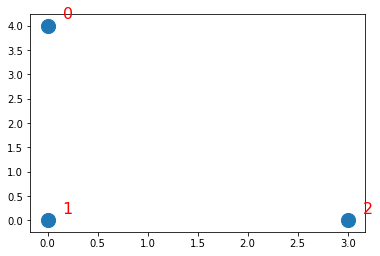

In [4]:
from scripts import utilities
from scripts import plots
import matplotlib.pyplot as plt
# cities = utilities.create_cities(3)
cities = np.array([[0, 4],[0, 0],[3, 0]])
distance_matrix = utilities.get_distance_matrix(cities)
plots.plot_cities(cities)
plt.show()

In [5]:
tsp_solver = ForestTSPSolverNaive(distance_matrix, use_constraints=True)
solution, naive_distribution = tsp_solver.solve_tsp()
print("The solution is:", solution)

                     models will be ineffective
	Parameters: [0.32120728 5.81929383] 
	E => -2225.902046395591
	Parameters: [0.32120728 5.81929383] 
	E => -2959.7191426814898
	Parameters: [0.32120728 5.81929383] 
	E => -2418.5086486322734
	Parameters: [0.32120728 5.81929383] 
	E => -2791.1897207746892
	Parameters: [0.32120728 5.81929383] 
	E => -2817.2141714650375
	Parameters: [0.32120728 5.81929383] 
	E => -2506.2053350309484
	Parameters: [0.32120728 5.81929383] 
	E => -2746.412355359732
	Parameters: [0.32120728 5.81929383] 
	E => -2461.5320208204657
	Parameters: [0.32120728 5.81929383] 
	E => -2917.102934101301
	Parameters: [0.32171701 5.81900969] 
	E => -2989.5439816908374
	Parameters: [0.32071324 5.81900969] 
	E => -2964.4265003113405
	Parameters: [0.3212112  5.81915176] 
	E => -2991.0777956864486
	Parameters: [0.32020743 5.81915176] 
	E => -2983.0174931466145
	Parameters: [0.32071128 5.81908073] 
	E => -2993.3252511963615
	Parameters: [0.31970751 5.81908073] 
	E => -2992.248956828

Wait a minute... This doesn't make sense at all. We wanted to get `[0, 1, 2]`, and I got `[0, 1, 2, 2]`. 
(Since the result is probabilistic, you might have gotten something different. Also every time I update this notebook I get something different, so sorry for some inconsistencies here.)
<br>
Maybe something is wrong with the `binary_state_to_points_order` in our solver? We should investigate the binary string.

In [6]:
print("Your binary solution is:", tsp_solver.most_frequent_string)
print("My initial binary solution is:", (1,1,1,0,0,0,0,0,1))

Your binary solution is: (1, 0, 0, 1, 0, 0, 0, 0, 1)
My initial binary solution is: (1, 1, 1, 0, 0, 0, 0, 0, 1)


This solution doesn't make sense at all! This string means, that at t=0 we are in all the cities at the same time, then at t=1 we are not present anywhere and at t=2 we are in the city 2.
<br>
It's not a surprise, that our order of traveling looks weird.

At this point you may have noticed something suspicious with our class. It's called `ForestTSPSolverNaive`.
<br>
"Naive"... It doesn't sound very promising to me. Let's see why I named it naive, what's actually inside it and why we got such a crappy solution.

In [7]:
distance_matrix = utilities.get_distance_matrix(cities)
print(distance_matrix)
number_of_cities = len(Cities)

[[0. 4. 5.]
 [4. 0. 3.]
 [5. 3. 0.]]


In [8]:
from pyquil.paulis import PauliTerm

cost_operators = []
number_of_cities = len(distance_matrix)

for city1 in range(number_of_cities):
    for city2 in range(city1, number_of_cities):
        for t in range(number_of_cities - 1):
            weight = -distance_matrix[city1][city2]/2
            if distance_matrix[city1][city2] != 0:
                qubit_1 = t * number_of_cities + i
                qubit_2 = (t + 1) * number_of_cities + j
                cost_operators.append(PauliTerm("I", 0, weight) - PauliTerm("Z", qubit_1, weight) * PauliTerm("Z", qubit_2))
                print("City", i, "to", j, "at t =", t, "costs", weight, "Qubits:", qubit_1, qubit_2)

City 0 to 1 at t = 0 costs -2.0 Qubits: 0 4
City 0 to 1 at t = 1 costs -2.0 Qubits: 3 7
City 0 to 2 at t = 0 costs -2.5 Qubits: 0 5
City 0 to 2 at t = 1 costs -2.5 Qubits: 3 8
City 1 to 2 at t = 0 costs -1.5 Qubits: 1 5
City 1 to 2 at t = 1 costs -1.5 Qubits: 4 8


In [9]:
for single_cost_operator in cost_operators:
    print(single_cost_operator)

(-2+0j)*I + (2-0j)*Z0*Z4
(-2+0j)*I + (2-0j)*Z3*Z7
(-2.5+0j)*I + (2.5-0j)*Z0*Z5
(-2.5+0j)*I + (2.5-0j)*Z3*Z8
(-1.5+0j)*I + (1.5-0j)*Z1*Z5
(-1.5+0j)*I + (1.5-0j)*Z4*Z8


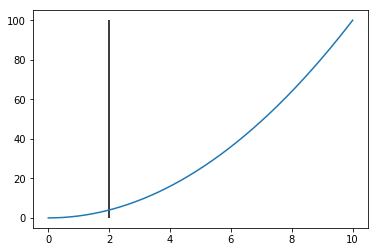

In [10]:
x = np.linspace(0, 10, 1000)
y = x**2
plt.plot(x,y)
plt.vlines(2, 0, 100)
plt.show()

In [11]:
pen = np.piecewise(x, [x<2, x>=2], [lambda x: 100*(-x+2)**3, 0])

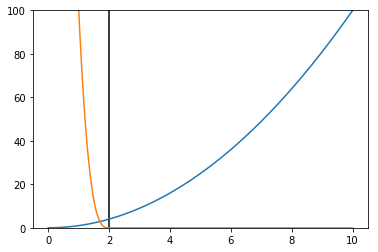

In [12]:
plt.plot(x,y)
plt.plot(x,pen)
plt.vlines(2, 0, 100)
plt.ylim([0,100])
plt.show()

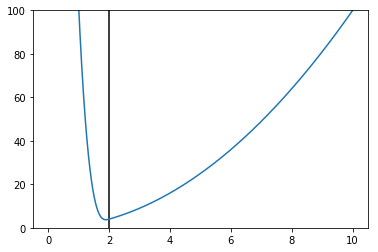

In [13]:
plt.plot(x,y + pen)
plt.vlines(2, 0, 100)
plt.ylim([0,100])
plt.show()

In [14]:
x[np.argmin(y+pen)]

1.8918918918918919

In [15]:
import numpy as np
Z = np.array([[1,0],[0,-1]])
np.eye(4) - np.kron(Z,Z)

array([[0., 0., 0., 0.],
       [0., 2., 0., 0.],
       [0., 0., 2., 0.],
       [0., 0., 0., 0.]])

What does it mean for us?
<br>
That if we need to find a way to construct such matrix using the Pauli gates that it will add huge penalty for the states we don't want.

As mentioned earlier, there are two types of constraints we have:
- we need to visit each city once
- in every moment we need to be in exactly one city

Let's take an example of 3 cities to make it clear how to encode these.

Our solution will be the following vector state: 
<br>
$\ket{\psi_{sol}} = \ket{q_1 q_2 q_3 q_4 q_5 q_6 q_7 q_8 q_9}$
<br>
Let's say, that at $t=0$ we want to visit only one city. This means, that the only possible states are $\ket{100}$, $\ket{010}$ and $\ket{001}$, so we want to penalize all the other states.
It turns out, that the following operator almost gives us what we want:

In [16]:
Z1Z2Z3 = np.kron(Z,np.kron(Z,Z))
print("Product of Z1, Z2 and Z3")
print(Z1Z2Z3)
print("Our operator")
basic_penalty = 0.5 * (np.eye(8) + Z1Z2Z3)
print(basic_penalty)

Product of Z1, Z2 and Z3
[[ 1  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0]
 [ 0  0  0  0 -1  0  0  0]
 [ 0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 -1]]
Our operator
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


This operator ignore the states we want and  will add penalty to all the others, namely: $\ket{000}$, $\ket{011}$, $\ket{101}$ and $\ket{110}$.

The only problem is, that it doesn't penalize state $\ket{111}$, but we can deal with that with the following addition:

In [17]:
helper_op = 0.5 * (np.eye(2) - Z)
print("Our helper operator:")
print(helper_op)
print("Our operator for 111 state:")
penalty_111 = np.kron(helper_op, np.kron(helper_op,helper_op))
print(penalty_111)

Our helper operator:
[[0. 0.]
 [0. 1.]]
Our operator for 111 state:
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


Now we can combine those operators to get our final penalty operator:

In [18]:
print("Final penalty operator")
final_penalty = basic_penalty + penalty_111
print(final_penalty)

Final penalty operator
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


Ok, so now we know how to deal with our very first constraint - being in only one city at the time, for the first time slot. We need to add penalty operator for qubits $q_1$, $q_2$, $q_3$, $P_{123}$, to our cost operators. With a proper weight, of course.
<br>
To deal with all the other time slots, we just need to work with other set of qubits, so have $P_{456}$ and $P_{789}$.

Now, we want to deal with the second constraint, that we can visit each city only once. Well, it's actually exactly the same situation, but this time instead of using qubits associated with the same time slot, we need to use qubits associated with the same cities. 
<br>
So operators: $P_{147}$, $P_{258}$ and $P_{369}$ will do the job.

Now we are ready to actually code it in pyQuil and add it to our cost operator.

In [19]:
def create_penalty_operators_for_qubits(qubits):
    pass

In [20]:
def create_penalty_operators_for_repetition(number_of_cities):
    pass

In [21]:
def create_penalty_operators_for_bilocation(number_of_cities):
    pass

In [22]:
def create_weights_cost_operators(distance_matrix):
    pass

In [23]:
def create_cost_operators(distance_matrix):
    pass


Now that we have the cost operators with the penalties ready, we try using it 

In [24]:
tsp_solver = ForestTSPSolverNaive(distance_matrix, use_constraints=True)
solution, naive_distribution = tsp_solver.solve_tsp()
print("The solution is:", solution)

                     models will be ineffective
	Parameters: [2.36630561 2.87194104] 
	E => -2659.729526109549
	Parameters: [2.36630561 2.87194104] 
	E => -2500.928153946556
	Parameters: [2.36630561 2.87194104] 
	E => -2649.549671687539
	Parameters: [2.36630561 2.87194104] 
	E => -2656.8578001498586
	Parameters: [2.36630561 2.87194104] 
	E => -2593.2672286683924
	Parameters: [2.36630561 2.87194104] 
	E => -2602.6375162862882
	Parameters: [2.36630561 2.87194104] 
	E => -2489.3044561287666
	Parameters: [2.36977187 2.87250197] 
	E => -2717.6451379467208
	Parameters: [2.36977187 2.87250197] 
	E => -2717.1651827131263
	Parameters: [2.36977187 2.87250197] 
	E => -2700.167597643281
	Parameters: [2.36780766 2.87278243] 
	E => -2690.609142205864
	Parameters: [2.37150501 2.87278243] 
	E => -2721.3134501326062
	Parameters: [2.37150501 2.87278243] 
	E => -2728.741501800037
	Parameters: [2.37150501 2.87278243] 
	E => -2731.8585776181585
	Parameters: [2.36967078 2.87274737] 
	E => -2732.389997910746

You might got a proper solution or not, but it's good to see what's the actual distribution of the results:

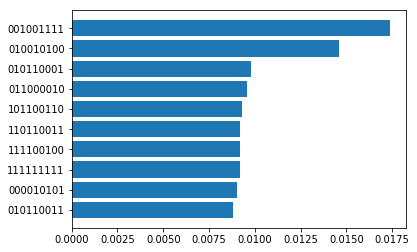

In [25]:
states_with_probs = []
for state in tsp_solver.sampling_results:
    states_with_probs.append([''.join(map(str,state)), tsp_solver.sampling_results[state]/10000])
states_with_probs = sorted(states_with_probs,key=lambda x: -x[1])
plots.plot_state_histogram(states_with_probs[:10][::-1])

Since it might be hard for you to decode the bitstrings, let's take a look at the human-readable representation.
The two might actually differ, since many bitstrings may have the same representation in a case of an invalid solution. That's why we call the distribution coming from tsp_solver a `naive_distribution`.

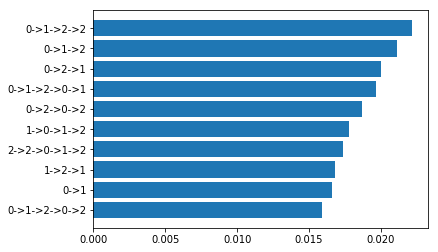

In [26]:
solutions_with_probs = []
for state in naive_distribution:
    solutions_with_probs.append(['->'.join(map(str,state)), naive_distribution[state]/10000])
solutions_with_probs = sorted(solutions_with_probs,key=lambda x: -x[1])

plots.plot_state_histogram(solutions_with_probs[:10][::-1])

As you can see, still many (if not most) of the solutions don't make sense. In the next part you will see how to further improve this algorithm.

What we learned?
- how to solve problem with constraints using QAOA
- how to encode constraints and costs for TSP

What's next?
- improving the algorithm!